In [1]:
import os
import h5py
import numpy as np

os.chdir("../scripts/data_preparation")  

# Clone fixed image to train
Start with images (formatted as just 1 fixed image from Weissbourd)

In [ ]:
old_fixed_h5 = "/home/brian/data4/brian/PBnJ/jelly_processed_data/h5/fixed_images.h5"
new_fixed_h5 = "/home/brian/data4/brian/PBnJ/jelly_processed_data/h5/fixed_fixed_images.h5"
moving_h5 = "/home/brian/data4/brian/PBnJ/jelly_processed_data/h5/moving_images.h5"
with h5py.File(old_fixed_h5, 'r') as f:
    assert len(f.keys()) == 1, "This is isn't the right program, bud"
    img = f[list(f.keys())[0]][:]
with h5py.File(new_fixed_h5, 'w-') as f:
    with h5py.File(moving_h5, 'r') as g:
        for prob in g.keys():
            f.create_dataset(prob, data = img)

AssertionError: This is isn't the right program, bud

Then do the same for labels

In [14]:
old_fixed_h5 = "/home/brian/data4/brian/PBnJ/jelly_processed_data/h5/fixed_labels.h5"
new_fixed_h5 = "/home/brian/data4/brian/PBnJ/jelly_processed_data/h5/fixed_fixed_labels.h5"
moving_h5 = "/home/brian/data4/brian/PBnJ/jelly_processed_data/h5/moving_labels.h5"
with h5py.File(old_fixed_h5, 'r') as f:
    assert len(f.keys()) == 1, "This is isn't the right program, bud"
    labs = f[list(f.keys())[0]][:]
with h5py.File(new_fixed_h5, 'w-') as f:
    with h5py.File(moving_h5, 'r') as g:
        for prob in g.keys():
            f.create_dataset(prob, data = labs)

: 

Now add a third column so the labels have three dimensions

In [ ]:
old_fixed_h5 = "/home/brian/data4/brian/PBnJ/jelly_processed_data/h5/fixed_labels.h5"
new_fixed_h5 = "/home/brian/data4/brian/PBnJ/jelly_processed_data/h5/fixed_fixed_labels.h5"
with h5py.File(old_fixed_h5, 'r') as f:
    assert f[list(f.keys())[0]][:].shape[1] == 2, "This is meant to expand the labels from 2D to 3D"
    with h5py.File(new_fixed_h5, 'w') as g:
        for prob in f.keys():
            labs = f[prob][:]
            labs = np.concatenate((labs, np.ones((labs.shape[0], 1))), 1)
            g.create_dataset(prob, data = labs)

And add a third dim for the images

In [ ]:
old_fixed_h5 = "/home/brian/data4/brian/PBnJ/jelly_processed_data/h5/fixed_images.h5"
new_fixed_h5 = "/home/brian/data4/brian/PBnJ/jelly_processed_data/h5/fixed_fixed_images.h5"
with h5py.File(old_fixed_h5, 'r') as f:
    assert len(f[list(f.keys())[0]][:].shape) == 2, "This is meant to expand the images from 2D to 3D"
    with h5py.File(new_fixed_h5, 'w') as g:
        for prob in f.keys():
            img = f[prob][:]
            img = np.expand_dims(img, 2)
            g.create_dataset(prob, data = img)

# Take unlabeled frames and add to a labeled h5

In [48]:
import random, cv2, os

old_img_fixed_h5 = "/home/brian/data4/brian/PBnJ/jelly_processed_data/h5/fixed_images.h5"
new_img_fixed_h5 = "/home/brian/data4/brian/PBnJ/jelly_processed_data/mixed_lab_h5/fixed_images.h5"

old_label_fixed_h5 = "/home/brian/data4/brian/PBnJ/jelly_processed_data/h5/fixed_labels.h5"
new_label_fixed_h5 = "/home/brian/data4/brian/PBnJ/jelly_processed_data/mixed_lab_h5/fixed_labels.h5"

old_img_moving_h5 = "/home/brian/data4/brian/PBnJ/jelly_processed_data/h5/moving_images.h5"
new_img_moving_h5 = "/home/brian/data4/brian/PBnJ/jelly_processed_data/mixed_lab_h5/moving_images.h5"

old_label_moving_h5 = "/home/brian/data4/brian/PBnJ/jelly_processed_data/h5/moving_labels.h5"
new_label_moving_h5 = "/home/brian/data4/brian/PBnJ/jelly_processed_data/mixed_lab_h5/moving_labels.h5"

frame_folder = "/home/brian/data4/brian/PBnJ/jelly_centroid_prep/zoomed_in_vid"

num_frames_to_add = 500

frame_names = [
    os.path.splitext(p)[0] for p in os.listdir(frame_folder)
    if os.path.splitext(p)[-1] in [".jpg"]
]

probs = []

for i in range(num_frames_to_add):
    probs.append(tuple(random.sample(frame_names, 2)))

# old_mean = 0
old_max = 0
# num = 0

with h5py.File(new_img_fixed_h5, 'w-') as nif:
    with h5py.File(new_label_fixed_h5, 'w-') as nlf:
        with h5py.File(old_img_fixed_h5, 'r') as oif:
            with h5py.File(old_label_fixed_h5, 'r') as olf:
                for prob in oif.keys():
                    img = oif[prob][:]
                    labs = olf[prob][:]

                    # old_mean += np.mean(img)
                    old_max = max(old_max, np.max(img))
                    # num += 1

                    nif.create_dataset(prob, data = img, dtype=float)
                    nlf.create_dataset(prob, data = labs, dtype=np.float32)
        
        # old_mean = old_mean / num
        scale_factor = old_max / 255 # Photo max val
        
        unlabeled_labs = np.ones_like(labs, dtype=np.float32) * -1
        for fixed, moving in probs:
            prob = f"{moving}to{fixed}"
            img = cv2.imread(os.path.join(frame_folder, fixed + ".jpg"))[:,:,0:1]
            nif.create_dataset(prob, data = img * scale_factor, dtype=float)
            nlf.create_dataset(prob, data = unlabeled_labs, dtype=np.float32)





with h5py.File(new_img_moving_h5, 'w-') as nim:
    with h5py.File(new_label_moving_h5, 'w-') as nlm:
        with h5py.File(old_img_moving_h5, 'r') as oim:
            with h5py.File(old_label_moving_h5, 'r') as olm:
                for prob in oim.keys():
                    img = oim[prob][:]
                    labs = olm[prob][:]
                    nim.create_dataset(prob, data = img, dtype=float)
                    nlm.create_dataset(prob, data = labs, dtype=np.float32)

        for fixed, moving in probs:
            prob = f"{moving}to{fixed}"
            img = cv2.imread(os.path.join(frame_folder, moving + ".jpg"))[:,:,0:1]
            nim.create_dataset(prob, data = img * scale_factor, dtype=float)
            nlm.create_dataset(prob, data = unlabeled_labs, dtype=np.float32)

In [34]:
with h5py.File(new_label_moving_h5, 'r') as f:
    print(list(f.keys()))

['10078to15011', '10411to15011', '10412to15011', '10419to15011', '10423to15011', '10456to15011', '10459to15011', '10523to15011', '12004to12042', '12009to12437', '12016to12202', '12037to12851', '12064to12300', '12064to12585', '12080to12150', '12091to12445', '12099to12331', '12120to12429', '12120to12814', '12133to12738', '12138to12772', '12161to12554', '12170to12029', '12175to12851', '12176to12764', '12180to12168', '12180to12442', '12187to12994', '12199to12789', '12206to12426', '12211to12791', '12233to15011', '12241to12251', '12253to12159', '12263to12836', '12270to12052', '12270to12802', '12284to12133', '12285to12967', '12287to12028', '12302to12067', '12316to12411', '12345to12110', '12359to12260', '12368to12511', '12384to12698', '12391to12580', '12406to12933', '12414to12607', '12416to12588', '12426to12777', '12462to12604', '12477to12741', '12484to12806', '12489to12378', '12493to12970', '12509to12762', '12515to12499', '12526to12782', '12538to12730', '12544to12981', '12547to12958', '12552t

# Split into training and val

In [12]:
val_probs = [
            "3563to15011",
            "5004to15011",
            "6739to15011",
            "8110to15011",
            "985to15011"
        ]


import random, cv2, os

base_dir = "/home/brian/data4/brian/PBnJ/jelly_processed_data/mixed_lab_padded"

os.mkdir(os.path.join(base_dir, "train"))
os.mkdir(os.path.join(base_dir, "val"))

old_img_fixed_h5 = f"{base_dir}/fixed_images.h5"
train_img_fixed_h5 = f"{base_dir}/train/fixed_images.h5"
val_img_fixed_h5 = f"{base_dir}/val/fixed_images.h5"

old_label_fixed_h5 = f"{base_dir}/fixed_labels.h5"
train_label_fixed_h5 = f"{base_dir}/train/fixed_labels.h5"
val_label_fixed_h5 = f"{base_dir}/val/fixed_labels.h5"

old_img_moving_h5 = f"{base_dir}/moving_images.h5"
train_img_moving_h5 = f"{base_dir}/train/moving_images.h5"
val_img_moving_h5 = f"{base_dir}/val/moving_images.h5"

old_label_moving_h5 = f"{base_dir}/moving_labels.h5"
train_label_moving_h5 = f"{base_dir}/train/moving_labels.h5"
val_label_moving_h5 = f"{base_dir}/val/moving_labels.h5"


with h5py.File(train_img_fixed_h5, 'w-') as tif,  h5py.File(val_img_fixed_h5, 'w-') as vif:
    with h5py.File(train_label_fixed_h5, 'w-') as tlf,  h5py.File(val_label_fixed_h5, 'w-') as vlf:
        with h5py.File(old_img_fixed_h5, 'r') as oif:
            with h5py.File(old_label_fixed_h5, 'r') as olf:
                for prob in oif.keys():
                    img = oif[prob][:]
                    labs = olf[prob][:]
                    if prob in val_probs:
                        vif.create_dataset(prob, data = img)
                        vlf.create_dataset(prob, data = labs)
                    else:
                        tif.create_dataset(prob, data = img)
                        tlf.create_dataset(prob, data = labs)
        

with h5py.File(train_img_moving_h5, 'w-') as tim,  h5py.File(val_img_moving_h5, 'w-') as vim:
    with h5py.File(train_label_moving_h5, 'w-') as tlm,  h5py.File(val_label_moving_h5, 'w-') as vlm:
        with h5py.File(old_img_moving_h5, 'r') as oim:
            with h5py.File(old_label_moving_h5, 'r') as olm:
                for prob in oim.keys():
                    img = oim[prob][:]
                    labs = olm[prob][:]
                    if prob in val_probs:
                        vim.create_dataset(prob, data = img)
                        vlm.create_dataset(prob, data = labs)
                    else:
                        tim.create_dataset(prob, data = img)
                        tlm.create_dataset(prob, data = labs)

### Create empty ROIs

In [4]:
base_dir = "/home/brian/data4/brian/PBnJ/jelly_processed_data/mixed_lab_padded"

old_img_moving_h5 = f"{base_dir}/moving_images.h5"

train_roi_moving_h5 = f"{base_dir}/train/moving_rois.h5"
val_roi_moving_h5 = f"{base_dir}/val/moving_rois.h5"
train_roi_fixed_h5 = f"{base_dir}/train/fixed_rois.h5"
val_roi_fixed_h5 = f"{base_dir}/val/fixed_rois.h5"


with h5py.File(val_roi_fixed_h5, 'w-') as vrf,  h5py.File(val_roi_moving_h5, 'w-') as vrm:
# with h5py.File(train_roi_fixed_h5, 'w-') as trf,  h5py.File(train_roi_moving_h5, 'w-') as trm:
    with h5py.File(old_img_moving_h5, 'r') as oim:
        for prob in oim.keys():
            blank = np.zeros_like(oim[prob][:])
            vrf.create_dataset(prob, data = blank)
            vrm.create_dataset(prob, data = blank)
            # trf.create_dataset(prob, data = blank)
            # trm.create_dataset(prob, data = blank)

## Add Padding

In [2]:
in_dir = "/home/brian/data4/brian/PBnJ/archive_pre_datadump/jelly_processed_data/h5"
out_dir = "/home/brian/data4/brian/PBnJ/jelly_h5s/double_padded/full-vals-old"

padding = np.array([[0,0],[0,0],[1,1]])

with h5py.File(os.path.join(in_dir, "moving_images.h5"), 'r') as imv,  h5py.File(os.path.join(in_dir, "moving_labels.h5"), 'r') as lmv:
    with h5py.File(os.path.join(out_dir, "moving_images.h5"), 'w-') as oimv,  h5py.File(os.path.join(out_dir, "moving_labels.h5"), 'w-') as olmv:
        for prob in imv.keys():
            img = imv[prob][:]
            img = np.pad(img, padding, "constant", constant_values=0)

            labs = lmv[prob][:]
            neg_ones = labs < 0
            # labs = labs + padding[:, 0] 
            labs[neg_ones] = -1 # Retain -1s

            oimv.create_dataset(prob, data = img)
            olmv.create_dataset(prob, data = labs)



with h5py.File(os.path.join(in_dir, "fixed_images.h5"), 'r') as ifx,  h5py.File(os.path.join(in_dir, "fixed_labels.h5"), 'r') as lfx:
    with h5py.File(os.path.join(out_dir, "fixed_images.h5"), 'w-') as oifx,  h5py.File(os.path.join(out_dir, "fixed_labels.h5"), 'w-') as olfx:
        for prob in ifx.keys():
            img = ifx[prob][:]
            img = np.pad(img, padding, "constant", constant_values=0)

            labs = lfx[prob][:]
            neg_ones = labs < 0
            # labs = labs + padding[:, 0] 
            labs[neg_ones] = -1 # Retain -1s
            
            oifx.create_dataset(prob, data = img)
            olfx.create_dataset(prob, data = labs)


# Actual Processing to create new datasets

In [31]:
from euler_register import EulerRegistrationProcessor

target_image_shape = (1080, 1080, 1)
save_directory = "/home/brian/data4/brian/PBnJ/jelly_processed_data"
problem_file = "/home/brian/notebooks/brian/PBrainAlign_and_Jelly/private_BrainAlignNet/scripts/data_preparation/resources/jelly_registration_problems.json"

processor = EulerRegistrationProcessor(
    target_image_shape,
    save_directory,
    problem_file
)
processor.process_datasets()

ModuleNotFoundError: No module named 'euler_register'

Add Padding

In [9]:
in_dir = "/home/brian/data4/brian/PBnJ/jelly_processed_data/mixed_lab_h5"
out_dir = "/home/brian/data4/brian/PBnJ/jelly_processed_data/mixed_lab_padded"

padding = np.array([[0,0],[0,0],[1,0]])

with h5py.File(os.path.join(in_dir, "moving_images.h5"), 'r') as imv,  h5py.File(os.path.join(in_dir, "moving_labels.h5"), 'r') as lmv:
    with h5py.File(os.path.join(out_dir, "moving_images.h5"), 'w-') as oimv,  h5py.File(os.path.join(out_dir, "moving_labels.h5"), 'w-') as olmv:
        for prob in imv.keys():
            img = imv[prob][:]
            img = np.pad(img, padding, "constant", constant_values=0)

            labs = lmv[prob][:]
            neg_ones = labs < 0
            labs = labs + padding[:, 0] 
            labs[neg_ones] = -1 # Retain -1s

            oimv.create_dataset(prob, data = img)
            olmv.create_dataset(prob, data = labs)



with h5py.File(os.path.join(in_dir, "fixed_images.h5"), 'r') as ifx,  h5py.File(os.path.join(in_dir, "fixed_labels.h5"), 'r') as lfx:
    with h5py.File(os.path.join(out_dir, "fixed_images.h5"), 'w-') as oifx,  h5py.File(os.path.join(out_dir, "fixed_labels.h5"), 'w-') as olfx:
        for prob in ifx.keys():
            img = ifx[prob][:]
            img = np.pad(img, padding, "constant", constant_values=0)

            labs = lfx[prob][:]
            neg_ones = labs < 0
            labs = labs + padding[:, 0] 
            labs[neg_ones] = -1 # Retain -1s
            
            oifx.create_dataset(prob, data = img)
            olfx.create_dataset(prob, data = labs)


## Convert vsi files to h5

In [ ]:
import bioformats
import javabridge

# Start the Java Virtual Machine (JVM)
javabridge.start_vm(class_path=bioformats.JARS)


# Open the VSI file using bioformats
with bioformats.ImageReader('your_vsi_file.vsi') as reader:
    # Read the image data
    image_data = reader.read(series=0, index=0)

plt.imshow(image_data)

# Stop the JVM
javabridge.kill_vm()

ModuleNotFoundError: No module named 'bioformats'

In [ ]:
import tifffile
import matplotlib.pyplot as plt

vsi_file = "/store1/brian/swiming_videos/Folder_20240911/20240911_Experiment_01.vsi"
vsi_file = "/store1/brian/swiming_videos/Folder_20240913/20240913_Experiment_01.vsi"


# with tifffile.TiffFile(vsi_file) as tif:
#     # VSI files can contain multiple images, so iterate through them.
#     for page in tif.pages:
#         image_data = page.asarray()

var = tifffile.imread(vsi_file)
print(var.shape)

# plt.imshow(image_data)


(512, 512, 3)


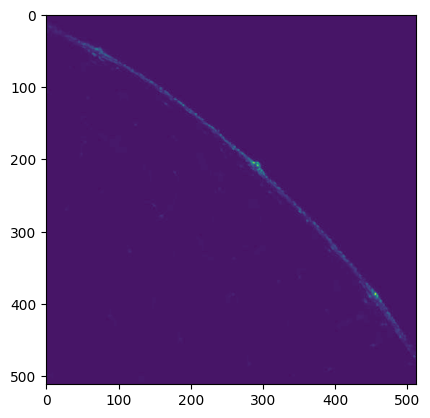

In [13]:
plt.imshow(var[...,0])